# Quantum Auto-Regressive Model Training
**Objective:** Train a Hybrid Quantum-Classical Neural Network to predict the next token in a molecular sequence, conditioned on global molecular properties (logP, QED, MW).

**Architecture:**
* **Input:** 5-bit token encodings + 3 continuous property values.
* **Ansatz:** A variational quantum circuit using Strongly Entangling Layers and Diagonal Phase rotations ($e^{-i \phi Z \otimes Z}$).
* **Training:** JAX-based optimization using the Adam optimizer.

In [1]:
from typing import Tuple, List, Dict, Any

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import QED
from rdkit.Chem import Draw
from IPython.display import display
import selfies as sf

import numpy as np
import math
from math import ceil, log2, comb
import re
import pandas as pd
import optax
import csv
import json
import itertools
from functools import partial
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import haiku as hk

import pennylane as qml
from pennylane.templates import StronglyEntanglingLayers

import jax
import jax.random as random
from jax import random
import jax.numpy as jnp
import jax.nn as jnn
from jax.nn.initializers import normal


# Data Preparation

In [2]:
# Load metadata from JSON
N_MOLECS = 8000
META_DATA_PATH = f"../data/metadata_selfies_{N_MOLECS}.json"
time = time.strftime("%d%m%Y_%H")

with open(META_DATA_PATH, "r") as f:
    metadata = json.load(f)

VOCABULARY_SIZE = metadata['vocabulary_size']
BITS_PER_TOKEN = metadata['bits_per_token']
MAX_LEN = metadata['max_sequence_length']
ALPHABET = metadata['alphabet']
min_logp = metadata['min_logP']
max_logp = metadata['max_logP']
min_qed = metadata['min_qed']
max_qed = metadata['max_qed']
min_mw = metadata['min_mw']
max_mw = metadata['max_mw']

print("Vocabulary Size:", VOCABULARY_SIZE)
print("Bits per Token:", BITS_PER_TOKEN)
print("Max Sequence Length:", MAX_LEN)
print("Alphabet:", ALPHABET)


Vocabulary Size: 30
Bits per Token: 5
Max Sequence Length: 31
Alphabet: ['<SOS>', '[#Branch1]', '[#Branch2]', '[#C]', '[#N]', '[=Branch1]', '[=Branch2]', '[=C]', '[=N]', '[=O]', '[=P]', '[=Ring1]', '[=S]', '[Br]', '[Branch1]', '[Branch2]', '[C]', '[Cl]', '[F]', '[I]', '[NH1]', '[N]', '[O]', '[PH1]', '[P]', '[Ring1]', '[Ring2]', '[S]', '<EOS>', '<PAD>']


In [3]:
# --- Auxiliary functions ---
def normalize(value, min_val, max_val, target_max=np.pi):
    ''' Normalize a value to a range [0, [0, pi] to later encode them as rotation angles'''
    norm = (value - min_val) / (max_val - min_val) * target_max
    return float(f"{norm:.3f}")

def denormalize(norm_value, min_val, max_val, target_max=np.pi):
    ''' Denormalize a value from [0, pi] back to its original range'''
    return (norm_value * (max_val - min_val) / target_max) + min_val

def token_to_index(token):
    ''' Map a SELFIES token to its corresponding index in the ALPHABET'''
    if token in ALPHABET:
        return ALPHABET.index(token)
    else:
        return None

def bits_to_index(bits):
    powers = 2 ** jnp.arange(len(bits) - 1, -1, -1)
    return jnp.dot(bits, powers).astype(jnp.int32)

In [4]:
PAD_index = token_to_index("<PAD>")
SOS_index = token_to_index("<SOS>")
EOS_index = token_to_index("<EOS>")

In [5]:
def load_dataset_bits_batch(csv_path, n_bits=BITS_PER_TOKEN):
    """
    Read the dataset from a CSV file and convert it into bit representations for quantum processing.
    Args:
        csv_path (str): Path to the CSV file containing the dataset.
        n_bits (int): Number of bits used to represent each token.
    Returns:
        Tuple containing:
            - X_bits (jnp.ndarray): Input bit representations of shape (N_Molecules, MAX_LEN-1, n_bits).
            - Props (jnp.ndarray): Molecular properties of shape (N_Molecules, 3).
            - Y_indices (jnp.ndarray): Target token indices of shape (N_Molecules, MAX_LEN-1).
    """
    
    df = pd.read_csv(csv_path, dtype=str)
    print("Dataset loaded with shape:", df.shape)
    
    # Properties: logP, qed, mw
    # Shape: (N_Moleculas, 3)
    # Types: float
    props = df.iloc[:, :3].astype(float).values
    
    # Tokens
    # Shape: (N_Moleculas, MAX_LEN)
    # Types: string (e.g., "00101")
    token_cols = df.iloc[:, 3:].values
    
    # Auxiliary function to convert a string of '0's and '1's to a list
    def str_to_bit_list(s):
        return [int(c) for c in s]

    # 3D array to hold all bits
    all_bits = np.array([
        [str_to_bit_list(token) for token in row] 
        for row in token_cols
    ])
    
    # X_bits: Input for the model.
    # Take all tokens except the last one.
    X_bits = all_bits[:, :-1, :] 
    
    # Y_ind: Target indices for the model.
    # Take all tokens except the first one.
    # Convert from bit strings to integer indices (for loss calculation).
    Y_indices = np.array([[int(t, 2) for t in row[1:]] for row in token_cols])

    return jnp.array(X_bits), jnp.array(props), jnp.array(Y_indices)


In [6]:
data_path_train = f"../data/structured_data_selfies_{N_MOLECS}_train.csv"
print("Loaded training data:")
X_bits, Props, Y_ind = load_dataset_bits_batch(data_path_train)

print("X_bits shape:", X_bits.shape) # (N, L, 5)
print("Props shape:", Props.shape)   # (N, 3)
print("Y_ind shape:", Y_ind.shape)   # (N, L)
print("------------------------------")


data_path_val = f"../data/structured_data_selfies_{N_MOLECS}_val.csv"
print("Loaded validation data:")
X_bits_val, Props_val, Y_ind_val = load_dataset_bits_batch(data_path_val)

print("X_bits shape:", X_bits_val.shape) # (N, L, 5)
print("Props shape:", Props_val.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_val.shape)   # (N, L)
print("------------------------------")


data_path_test = f"../data/structured_data_selfies_{N_MOLECS}_test.csv"
print("Loaded validation data:")
X_bits_test, Props_test, Y_ind_test = load_dataset_bits_batch(data_path_test)

print("X_bits shape:", X_bits_test.shape) # (N, L, 5)
print("Props shape:", Props_test.shape)   # (N, 3)
print("Y_ind shape:", Y_ind_test.shape)   # (N, L)

Loaded training data:
Dataset loaded with shape: (667, 34)
X_bits shape: (667, 30, 5)
Props shape: (667, 3)
Y_ind shape: (667, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (143, 34)
X_bits shape: (143, 30, 5)
Props shape: (143, 3)
Y_ind shape: (143, 30)
------------------------------
Loaded validation data:
Dataset loaded with shape: (143, 34)
X_bits shape: (143, 30, 5)
Props shape: (143, 3)
Y_ind shape: (143, 30)


## Quantum Circuit

### The Quantum Circuit (Variational Ansatz)

This is the core of the implementation. The circuit accepts:
1.  **Molecular Properties:** Encoded via $R_y(\theta)$ rotations.
2.  **Current Token:** Encoded via Basis Embedding.
3.  **Context Vector:** Encoded via rotations.

The ansatz consists of $L$ layers of:
1.  **Unitary $V(\theta)$:** Strongly Entangling layers to mix information.
2.  **Diagonal $\Sigma(\gamma)$:** Multi-Z rotations to introduce non-linearity and entanglement specific to the Ising Hamiltonian structure often found in quantum dynamics.


To overcome the limited expressibility of NISQ circuits, we implemented a **Data Re-uploading scheme** where conditional information (molecular properties and attention context) is encoded into the circuit depth-wise. This allows the quantum model to approximate higher-degree polynomials of the input features, essential for capturing the complex discrete logic of SMILES syntax.

In [7]:
def zstring_combos(wires):
    """
    Return an ordered list of wire-tuples for all Z-strings up to order H_LOCAL.
    Order: all 1-local, then all 2-local, ..., up to H_LOCAL.
    """
    L = []
    for k in range(1, H_LOCAL + 1):
        L.extend(itertools.combinations(wires, k))
    return [tuple(c) for c in L]

def num_zstrings(n_wires):
    """
    Count how many Z-strings up to order H_LOCAL.
    """
    return sum(comb(n_wires, k) for k in range(1, H_LOCAL + 1))

In [8]:
# Circuit parameters ----------------------------------------------------------------------
N_LAYERS = 6  # number of variational layers
H_LOCAL = 2 # h_local sets the maximum number of qubits that can interact in each Z term
# ------------------------------------------------------------------------------------------


# Name the qubit wires explicitly
n_prop_qubits = 3  # number of qubits needed to encode properties (logP, QED, MW)
n_ancillas = 3  # number of ancilla qubits that represent the environment
n_total_qubits = n_prop_qubits + BITS_PER_TOKEN + n_ancillas

prop_wires = [f"prop_{i}" for i in range(n_prop_qubits)]
token_wires = [f"token_{i}" for i in range(BITS_PER_TOKEN)]
ancilla_wires = [f"ancilla_{i}" for i in range(n_ancillas)]
all_wires = prop_wires + token_wires + ancilla_wires

dev = qml.device("default.qubit", wires=all_wires)
#dev = qml.device("lightning.qubit", wires=all_wires)


def molecular_property_encoder(props, prop_scaling):
    """Encode continuous props on property qubits via RY rotations"""
    # Element-wise multiplication of property value * learnable scale
    scaled_props = props * prop_scaling

    for wire, val in zip(prop_wires, scaled_props):
        qml.RY(val, wires=wire)


def token_encoder(token_bits):
    """Soft basis encoding using RX rotation"""
    for i in range(BITS_PER_TOKEN):
        angle = token_bits[i] * jnp.pi 
        qml.RX(angle, wires=token_wires[i])


def operator_layer(theta_params, theta_prop, wires):
    """
    Variational layer where:
      - theta_params[...] are rotations for token + ancilla qubits
      - theta_prop encodes property→token entanglement
    """
    token_ancilla_ws = token_wires + ancilla_wires

    # Property → token entanglement 
    for p, prop_wire in enumerate(prop_wires):
        for t, t_a_wire in enumerate(token_ancilla_ws):
            qml.CRX(theta_prop[p, t, 0], wires=[prop_wire, t_a_wire])
            qml.CRY(theta_prop[p, t, 1], wires=[prop_wire, t_a_wire])

    # Strongly entangling layers on token + ancilla qubits
    qml.StronglyEntanglingLayers(
        weights=theta_params[None,:,:],  # shape: (n_token_ancilla, 3)
        wires=token_ancilla_ws
    )

def Sigma_layer_vec(gamma_vec, token_ancilla_ws, time=1.0, combos=None):
    """
    Diagonal multi-Z unitary Σ = exp(i * sum_s gamma_s * Z^{⊗|s|} * t)
    using a flat parameter vector 'gamma_vec' aligned with 'combos'.
    """
    if combos is None:
        combos = zstring_combos(token_ancilla_ws)

    # Safety: ensure the vector length matches the number of combos
    assert gamma_vec.shape[0] == len(combos), \
        f"gamma_vec has length {gamma_vec.shape[0]} but expected {len(combos)}"

    # MultiRZ(phi) = exp(-i * phi/2 * Z^{⊗k}); choose phi = -2 * gamma * time
    for gamma, combo in zip(gamma_vec, combos):
        qml.MultiRZ(-2.0 * gamma * time, wires=list(combo))


@qml.qnode(dev, interface="jax", diff_method="backprop")
def autoregressive_model(token_bits, props, theta_params, theta_prop, sigma_params, prop_scaling):
    """
    QNode for the autoregressive model.
    Args:
        token_bits: Bit representation of input tokens (shape: BITS_PER_TOKEN,)
        props: Molecular properties (shape: 3,)
        theta_params: Variational parameters for operator layers (shape: N_LAYERS, n_token_ancilla, 3)
        theta_prop: Property entanglement parameters (shape: N_LAYERS, n_prop_qubits, n_token_ancilla, 2)
        sigma_params: Parameters for Sigma layers (shape: N_LAYERS, num_zstrings)
    Returns:
        Probabilities over token qubits and expectation values of property qubits.
    """
    token_encoder(token_bits)              # Basis-encode token bits

    token_ancilla_ws = token_wires + ancilla_wires
    combos = zstring_combos(token_ancilla_ws)

    for l in range(N_LAYERS):
        # Re-inject properties and context at every layer
        molecular_property_encoder(props, prop_scaling)
        
        # Forward V(θ)
        operator_layer(theta_params[l], theta_prop[l], wires=all_wires)

        # Diagonal Σ(γ,t): vector API
        Sigma_layer_vec(sigma_params[l], token_ancilla_ws, time=1.0, combos=combos)

        # Backward V(θ)†
        qml.adjoint(operator_layer)(theta_params[l], theta_prop[l], wires=all_wires)

    return qml.probs(wires=token_wires), [qml.expval(qml.PauliZ(w)) for w in prop_wires]


### Classical Embedding

In [9]:
def prepare_sliding_window_context(x_batch, window_size=3):
    """
    Creates the context input for the Embedding Network for the entire batch/sequence.
    Args:
        x_batch: (Batch, Length, Bits)
        window_size: Number of previous tokens to include in the context
    Returns:
        context_matrix: (Batch, Length, window_size * Bits)
    """
    B, L, Bits = x_batch.shape
    
    # 1. Pad the beginning with SOS tokens (zeros) so t=0 has a valid context
    # We need 'window_size' padding steps
    padding = jnp.zeros((B, window_size, Bits), dtype=x_batch.dtype)
    padded_x = jnp.concatenate([padding, x_batch], axis=1) # (B, L + window, Bits)
    
    # 2. Create the sliding windows
    # We want context at t to contain: t-3, t-2, t-1
    windows = []
    for i in range(L):
        # Slice a window of 3 tokens, flatten them to a single vector
        # Slice from i to i+window_size
        window = padded_x[:, i : i + window_size, :] # (B, 3, 5)
        flat_window = window.reshape(B, -1)          # (B, 15)
        windows.append(flat_window)
        
    return jnp.stack(windows, axis=1) # (B, L, 15)

# Update Embedding Network to handle generic shapes (Haiku is flexible by default)
def embedding_network_fn(x):
    # We expect input x to be (..., window_size * bits)
    # Output must match theta shape: (N_LAYERS * n_token_ancilla * 3)
    output_dim = N_LAYERS * (BITS_PER_TOKEN + n_ancillas) * 3
    
    mlp = hk.Sequential([
        hk.Linear(64), jax.nn.relu,
        hk.Linear(64), jax.nn.relu,
        hk.Linear(output_dim) 
    ])
    return mlp(x)

embedding_network = hk.transform(embedding_network_fn)

### Loss Function
We train on a composite loss function:
$$\mathcal{L}_{total} = \mathcal{L}_{CE} + \alpha \mathcal{L}_{Props}$$
1.  **Cross Entropy ($\mathcal{L}_{CE}$):** Ensures the model predicts the correct next token (with Label Smoothing to prevent overfitting).
2.  **Property Regression ($\mathcal{L}_{Props}$):** Regularizes the latent space by ensuring the quantum circuit still retains information about the desired properties (logP, QED, MW) at the output measurement stage.

In [10]:
def total_loss_fn(pred_probs, prop_expvals, target_indices, props, alpha=0.5, epsilon=0.1):
    """
    Computes normalized loss for a Batch of sequences.
    Handles prop_expvals whether it comes as a list or an array.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        prop_expvals: (Batch, Length, P) or List of (Batch, Length) arrays - Predicted property expectation values
        target_indices: (Batch, Length) - Target token indices
        props: (Batch, P) - Target molecular properties
        alpha: Weighting factor for property loss
        epsilon: Label smoothing factor for cross-entropy loss
    Returns:
        Normalized combined loss (scalar)
    """
    # Handle List vs Array Input
    if isinstance(prop_expvals, list) or isinstance(prop_expvals, tuple):
        # If it's a list of (B, L) arrays, stack them to get (B, L, P)
        prop_expvals = jnp.stack(prop_expvals, axis=-1)
        
    # 1. Get dimensions
    # Now prop_expvals is guaranteed to be (B, L, P)
    vocab_size = pred_probs.shape[-1] 
    B, L, P = prop_expvals.shape 
    
    # 2. Flatten dimensions for easier processing (B*L, Vocab)
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = target_indices.reshape(-1)
    
    # 3. Cross-Entropy with Label Smoothing
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    smooth_target = jnp.full_like(flat_probs, epsilon / (vocab_size - 1))
    smooth_target = jnp.where(target_one_hot == 1, 1.0 - epsilon, smooth_target)
    
    loss_per_token = -jnp.sum(smooth_target * jnp.log(flat_probs + 1e-10), axis=-1)

    # 4. Property Loss (MSE)
    # Properties were encoded as RY(theta) rotations. Since the expectation value 
    # of PauliZ is cos(theta), we compare output <Z> to cos(input_props).
    target_props = jnp.cos(props)[:, None, :] 
    target_props = jnp.broadcast_to(target_props, (B, L, P))
    
    # Flatten both to (B*L, P) for calculation
    flat_target_props = target_props.reshape(-1, P)
    flat_expvals = prop_expvals.reshape(-1, P)
    
    # Mean MSE across the properties (axis=-1)
    prop_loss_per_token = jnp.mean((flat_expvals - flat_target_props) ** 2, axis=-1)

    # 5. Masking (Ignore PAD tokens)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # Average only over REAL tokens
    num_real_tokens = jnp.sum(mask) + 1e-9
    mean_ce = jnp.sum(loss_per_token * mask) / num_real_tokens
    mean_prop = jnp.sum(prop_loss_per_token * mask) / num_real_tokens

    # 6. Combine & Normalize
    combined_loss = mean_ce + alpha * mean_prop
    
    max_loss_scale = jnp.log(vocab_size) + alpha * 4.0
    
    return combined_loss / max_loss_scale

    
def compute_accuracy_masked(pred_probs, target_indices):
    """
    Calculates accuracy over non-PAD tokens.
    Args:
        pred_probs: (Batch, Length, Vocab) - Predicted token probabilities
        target_indices: (Batch, Length) - Target token indices
    Returns:
        Normalized accuracy (scalar)
    """
    # Get the predicted token indices (highest probability)
    predicted_indices = jnp.argmax(pred_probs, axis=-1)
    
    # Compare predictions to targets
    correct_predictions = (predicted_indices == target_indices)
    
    # Make to ignore PAD tokens
    mask = (target_indices != PAD_index)
    
    # Sum correct predictions over non-PAD tokens
    numerator = jnp.sum(correct_predictions * mask)
    
    # Divide by number of non-PAD tokens (epsilon to avoid div by zero)
    denominator = jnp.sum(mask) + 1e-9
    
    return numerator / denominator


## Model Training and Validation

This section implements the core optimization process. For each epoch, the execution follows two distinct phases:

1.  **Training Phase:** The model iterates over the **Training Set**, calculating gradients and updating the variational parameters ($\theta$) to minimize the combined loss function.
2.  **Validation Phase:** The model evaluates its current state on the held-out **Validation Set**. This is a **pure inference** step (no backpropagation) that strictly measures performance without updating weights.

**Objective:** By monitoring Validation Loss alongside Training Loss, we assess the model's ability to **generalize** to unseen chemical structures. This allows us to implement **Checkpointing**: we save the model parameters *only* when the Validation Loss reaches a new minimum, effectively preventing overfitting by discarding epochs where the model begins to memorize the training data.

In [11]:
# Token embedding parameters
rng = jax.random.PRNGKey(0)
dummy_context = jnp.zeros((3 * BITS_PER_TOKEN,), dtype=jnp.float32)  # 3 prev. tokens
embedding_params = embedding_network.init(rng, dummy_context)

# Effective qubit counts in variational layers
n_token_ancilla = BITS_PER_TOKEN + n_ancillas

# Initialize theta and sigma params
key = jax.random.PRNGKey(42)
key, k_theta, k_theta_prop, k_sigma, k_scale = jax.random.split(key, 5)

# Trainable scaling factors for [logP, QED, MW] initialize around 1.0
prop_scaling = jax.random.normal(k_scale, (3,)) * 0.1 + 1.0

# Precompute Z-string combos once
token_ancilla_ws = token_wires + ancilla_wires
combos = zstring_combos(token_ancilla_ws)
n_strings = len(combos)

# Combine all trainable parameters into a single dictionary
combined_params = {
    'theta': jax.random.normal(k_theta, (N_LAYERS, n_token_ancilla, 3)) * 0.1,
    'theta_prop': jax.random.normal(k_theta_prop, (N_LAYERS, n_prop_qubits, n_token_ancilla, 4)) * 0.1,
    'sigma': jax.random.normal(k_sigma, (N_LAYERS, n_strings)) * 0.1,
    'embedding': embedding_params,
    'prop_scaling': prop_scaling
}

# Training hyperparams
N_EPOCHS = 100
BATCH_SIZE = 16  # Puedes probar 16 o 64 según tu memoria RAM/VRAM
N_SAMPLES = len(X_bits)
STEPS_PER_EPOCH = N_SAMPLES // BATCH_SIZE

# Optimizer with Scheduler: warm up for 10 epochs, then decay
total_steps = N_EPOCHS * STEPS_PER_EPOCH
'''schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,                     # Start from 0 to warm up
    peak_value=1e-3,                    # Peak learning rate
    warmup_steps=10 * STEPS_PER_EPOCH, 
    decay_steps=total_steps,                
    end_value=1e-5                      # End with a very small rate to fine-tune
)'''
schedule = optax.cosine_decay_schedule(
    init_value=0.005, 
    decay_steps=200 * STEPS_PER_EPOCH, 
    alpha=0.1
)

optimizer = optax.adam(learning_rate=schedule)
#optimizer = optax.adam(1e-3)

opt_state = optimizer.init(combined_params)

In [12]:
# Cell: Batched Prediction (Params Dictionary)

# 1. Define the prediction logic for a single token step
def single_token_step(params, x_token, x_props, context_vec):
    """
    Predicts for a single token in a sequence using the params dictionary.
    """
    # Unpack parameters from the dictionary
    theta_base = params['theta']
    theta_prop = params['theta_prop']
    sigma = params['sigma']
    emb_params = params['embedding']
    prop_scaling = params['prop_scaling']

    # A. Run Embedding Network to get Theta Shift
    delta_theta_flat = embedding_network.apply(emb_params, None, context_vec)
    
    # Reshape to match Quantum Circuit Parameters (N_LAYERS, n_wires, 3)
    n_layers, n_wires, n_dims = theta_base.shape
    delta_theta = delta_theta_flat.reshape((n_layers, n_wires, n_dims))
    
    # B. Apply Shift
    theta_effective = theta_base + delta_theta
    
    # C. Run Quantum Circuit
    return autoregressive_model(x_token, x_props, theta_effective, theta_prop, sigma, prop_scaling)

# 2. Vectorize over Sequence Length (L)
sequence_predict = jax.vmap(
    single_token_step, 
    in_axes=(None, 0, None, 0) 
    # params: None      (Shared)
    # x_token: 0        (Iterate over L)
    # x_props: None     (Shared for all tokens in molecule)
    # context_vec: 0    (Iterate over L)
)

# 3. Vectorize over Batch (B)
batch_predict = jax.vmap(
    sequence_predict,
    in_axes=(None, 0, 0, 0)
    # params: None      (Shared)
    # x_batch: 0        (Iterate over Batch)
    # props_batch: 0    (Iterate over Batch)
    # context_batch: 0  (Iterate over Batch)
)

In [13]:
@jax.jit
def training_step_batched(params, opt_state, x_batch, props_batch, y_indices_batch):
    
    def loss_fn(params):
        # 1. Prepare Context
        context_batch = prepare_sliding_window_context(x_batch, window_size=3)
        
        # 2. Run Batch Prediction
        pred_probs, prop_expvals = batch_predict(
            params, 
            x_batch, 
            props_batch, 
            context_batch
        )
        
        # 3. Calculate Loss
        loss = total_loss_fn(pred_probs, prop_expvals, y_indices_batch, props_batch)
        return loss, pred_probs

    # Compute Gradients
    (loss, pred_probs), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    
    # Update Weights
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    
    # Calculate Accuracy
    acc = compute_accuracy_masked(pred_probs, y_indices_batch)
    
    # Return 5 values: params, loss, state, grads, accuracy
    return new_params, loss, opt_state, grads, acc

In [14]:

@jax.jit
def validation_step_batched(params, x_bits_batch, prop_batch, y_target_indices):
    
    # 1. Context
    context_batch = prepare_sliding_window_context(x_bits_batch, window_size=3)
    
    # 2. Prediction (Clean signature)
    pred_probs, prop_expvals = batch_predict(
        params, 
        x_bits_batch, 
        prop_batch, 
        context_batch
    )
    
    # 3. Metrics
    loss = total_loss_fn(pred_probs, prop_expvals, y_target_indices, prop_batch)
    acc = compute_accuracy_masked(pred_probs, y_target_indices)
    
    return loss, acc

In [15]:
print(f"Starting training with {N_SAMPLES} molecules.")
print(f"Batch Size: {BATCH_SIZE} | Steps per epoch: {STEPS_PER_EPOCH}")

# Create directory for checkpoints if it doesn't exist
ckpt_dir = '../data/params/'
os.makedirs(ckpt_dir, exist_ok=True)

key = random.PRNGKey(42)

loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []
best_val_loss = float('inf')

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time() # Track time per epoch

    # --- Training Phase ---
    total_loss = 0.0
    total_acc = 0.0

    # Shuffle data at the start of each epoch to improve generalization
    key, subkey = random.split(key)
    perm = random.permutation(subkey, N_SAMPLES)
    X_shuffled = X_bits[perm]
    P_shuffled = Props[perm]
    Y_shuffled = Y_ind[perm]

    for step in range(0, N_SAMPLES, BATCH_SIZE):
        # 1. Create the Batch (Slicing)
        idx_end = min(step + BATCH_SIZE, N_SAMPLES)
        
        x_batch = X_shuffled[step:idx_end]      # (BATCH_SIZE, 30, 5)
        prop_batch = P_shuffled[step:idx_end]   # (BATCH_SIZE, 3)
        y_batch = Y_shuffled[step:idx_end]      # (BATCH_SIZE, 30)
        
        if len(x_batch) == 0: continue

        # 2. Train all the batch at once
        combined_params, loss, opt_state, grads, acc = training_step_batched(
            combined_params, 
            opt_state, 
            x_batch, 
            prop_batch, 
            y_batch
        )
        
        # 3. Accumulate metrics
        batch_n = len(x_batch)
        total_loss += loss * batch_n
        total_acc += acc * batch_n
        grad_norm = optax.global_norm(grads)
 
    # Average metrics over epoch
    avg_loss = total_loss / N_SAMPLES
    avg_acc = total_acc / N_SAMPLES

    loss_history.append(float(avg_loss))
    acc_history.append(float(avg_acc))


    # ------ Validation Phase ------
    val_total_loss = 0.0
    val_total_acc = 0.0
    N_VAL = len(X_bits_val)
    
    # Iterate through Validation Data
    for v_step in range(0, N_VAL, BATCH_SIZE):
        v_idx_end = min(v_step + BATCH_SIZE, N_VAL)
        
        vx_batch = X_bits_val[v_step:v_idx_end]
        vp_batch = Props_val[v_step:v_idx_end]
        vy_batch = Y_ind_val[v_step:v_idx_end]
        
        if len(vx_batch) == 0: continue

        # Pure Inference (No optimizer update, no gradients)
        v_loss, v_acc = validation_step_batched(
            combined_params, 
            vx_batch, 
            vp_batch, 
            vy_batch
        )
        
        v_batch_n = len(vx_batch)
        val_total_loss += v_loss * v_batch_n
        val_total_acc += v_acc * v_batch_n

    val_avg_loss = val_total_loss / N_VAL
    val_avg_acc = val_total_acc / N_VAL
    val_loss_history.append(float(val_avg_loss))
    val_acc_history.append(float(val_avg_acc))

    epoch_time = time.time() - epoch_start_time

    # Print both Train and Val metrics
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f} | Val Loss: {val_avg_loss:.4f} | Val Acc: {val_avg_acc:.4f} | Time: {epoch_time:.2f}s")

    # Checkpointing (Save Best Model)
    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        
        # Save with a specific name indicating it is the "best"
        save_path = os.path.join(ckpt_dir, f"embedding_params_{N_MOLECS}_BEST.pkl")
        
        with open(save_path, "wb") as f:
            pickle.dump(combined_params, f)

Starting training with 667 molecules.
Batch Size: 16 | Steps per epoch: 41
Epoch 001 | Train Loss: 0.6465 | Train Acc: 0.2389 | Val Loss: 0.5649 | Val Acc: 0.3640 | Time: 267.76s
Epoch 002 | Train Loss: 0.5314 | Train Acc: 0.4079 | Val Loss: 0.5114 | Val Acc: 0.4267 | Time: 137.33s
Epoch 003 | Train Loss: 0.4916 | Train Acc: 0.4609 | Val Loss: 0.4879 | Val Acc: 0.4785 | Time: 115.09s
Epoch 004 | Train Loss: 0.4734 | Train Acc: 0.4878 | Val Loss: 0.4739 | Val Acc: 0.4910 | Time: 114.44s
Epoch 005 | Train Loss: 0.4615 | Train Acc: 0.5060 | Val Loss: 0.4658 | Val Acc: 0.5089 | Time: 114.95s
Epoch 006 | Train Loss: 0.4542 | Train Acc: 0.5187 | Val Loss: 0.4578 | Val Acc: 0.5165 | Time: 113.97s
Epoch 007 | Train Loss: 0.4494 | Train Acc: 0.5240 | Val Loss: 0.4548 | Val Acc: 0.5162 | Time: 114.09s
Epoch 008 | Train Loss: 0.4462 | Train Acc: 0.5299 | Val Loss: 0.4519 | Val Acc: 0.5196 | Time: 115.54s
Epoch 009 | Train Loss: 0.4432 | Train Acc: 0.5361 | Val Loss: 0.4498 | Val Acc: 0.5252 | Tim

### Training and Validation Visualization
To verify convergence and check for overfitting, we visualize the loss landscape and prediction accuracy over time for both the training and validation sets.

* **Loss (Blue/Navy):** Represents the combined objective (Cross-Entropy + Property MSE).
    * **Solid Line:** Training Loss. A steady decrease indicates the circuit is successfully learning.
    * **Dashed Line:** Validation Loss. If this starts increasing while Training Loss decreases, the model is overfitting.
* **Accuracy (Orange/Red):** Measures the percentage of correctly predicted next-tokens (masked for padding).
    * **Solid Line:** Training Accuracy.
    * **Dashed Line:** Validation Accuracy. This is the true measure of generalization.

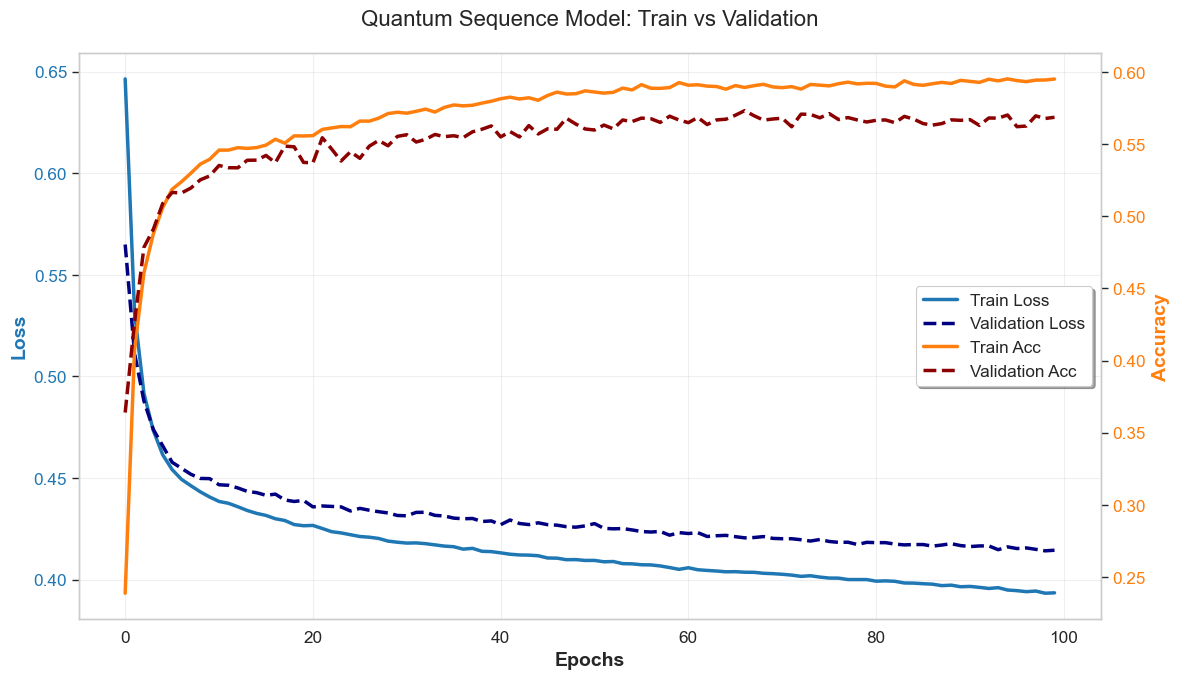

In [16]:
# Set the aesthetic style
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

# Create figure and primary axis (Loss)
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- Plot Loss (Left Axis) ---
color_train_loss = 'tab:blue'
color_val_loss = 'navy'

ax1.set_xlabel('Epochs', fontsize=14, fontweight='bold')
ax1.set_ylabel('Loss', color=color_train_loss, fontsize=14, fontweight='bold')

# Train Loss (Solid)
line1 = ax1.plot(loss_history, color=color_train_loss, linewidth=2.5, label='Train Loss')
# Val Loss (Dashed)
line2 = ax1.plot(val_loss_history, color=color_val_loss, linewidth=2.5, linestyle='--', label='Validation Loss')

ax1.tick_params(axis='y', labelcolor=color_train_loss)
ax1.grid(True, alpha=0.3)

# --- Plot Accuracy (Right Axis) ---
ax2 = ax1.twinx()
color_train_acc = 'tab:orange'
color_val_acc = 'darkred'

ax2.set_ylabel('Accuracy', color=color_train_acc, fontsize=14, fontweight='bold')

# Train Accuracy (Solid)
line3 = ax2.plot(acc_history, color=color_train_acc, linewidth=2.5, label='Train Acc')
# Val Accuracy (Dashed)
line4 = ax2.plot(val_acc_history, color=color_val_acc, linewidth=2.5, linestyle='--', label='Validation Acc')

ax2.tick_params(axis='y', labelcolor=color_train_acc)
ax2.grid(False)

# --- Combined Legend ---
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right', frameon=True, fancybox=True, shadow=True)

# Title and Layout
plt.title('Quantum Sequence Model: Train vs Validation', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## Final Test Phase: Unbiased Evaluation

This section performs the final evaluation of the optimized model on the **Test Set**, which has been completely withheld during the training and hyperparameter tuning phases.

**Objective:** To report the true generalization performance of the model on unseen data.

**Process:**
1.  **Load Best Model:** We load the model parameters that achieved the lowest validation loss.
2.  **Conditioned Generation:** For each set of molecular properties (LogP, QED, MW) in the Test Set, we generate a new molecule.
3.  **Metric Calculation:** We compute standard generative metrics:
    * **Validity:** Percentage of generated sequences that decode to valid chemical structures.
    * **Uniqueness:** Percentage of valid molecules that are unique.
    * **Novelty:** Percentage of valid molecules that do not appear in the Training Set.

In [18]:
# Load best model parameters
ckpt_dir = '../data/params/'
with open(os.path.join(ckpt_dir, f"selfies_params_{N_MOLECS}_BEST.pkl"), "rb") as f:
    combined_params = pickle.load(f)

In [19]:
# Cell: Batched NLL Calculation Step
@jax.jit
def calculate_nll_step(params, x_bits_batch, prop_batch, y_target_indices):
    """
    Calculates the Negative Log-Likelihood (NLL) for a batch of sequences.
    Adapted for Embedding-Theta model using Sliding Window Context.
    """
    # 1. Prepare Context (Teacher Forcing with Sliding Window)
    # We reuse the helper function defined for training
    context_batch = prepare_sliding_window_context(x_bits_batch, window_size=3)
    
    # 2. Run Batch Prediction
    # Using the params dictionary signature
    pred_probs, _ = batch_predict(
        params,
        x_bits_batch, 
        prop_batch, 
        context_batch
    )

    # 3. Calculate NLL (Pure Cross-Entropy, no label smoothing, masked)
    vocab_size = pred_probs.shape[-1]
    
    # Flatten for easier calculation
    flat_probs = pred_probs.reshape(-1, vocab_size)
    flat_targets = y_target_indices.reshape(-1)
    
    # Create One-Hot targets
    target_one_hot = jax.nn.one_hot(flat_targets, vocab_size)
    
    # NLL = -Sum( log(probability of correct token) )
    # Add epsilon for numerical stability
    per_token_nll = -jnp.sum(target_one_hot * jnp.log(flat_probs + 1e-10), axis=-1)
    
    # Mask Padding (Uses Global PAD_index)
    mask = (flat_targets != PAD_index).astype(jnp.float32)
    
    # Return total NLL and total count of tokens (for averaging later)
    return jnp.sum(per_token_nll * mask), jnp.sum(mask)

def get_test_set_nll(params, test_x, test_props, test_y):
    """ 
    Computes the average NLL per token over the test dataset.
    Args:
        params: Model parameters
        test_x: Test input bits (N, L, 5)
        test_props: Test molecular properties (N, 3)
        test_y: Test target token indices (N, L)
    Returns:
        Average NLL per token (scalar)
    """
    total_nll = 0.0
    total_tokens = 0.0
    
    # Loop through the dataset
    for i in range(0, len(test_x), BATCH_SIZE):
        # Calculate end index
        idx_end = min(i + BATCH_SIZE, len(test_x))
        
        # Create the batch
        batch_x = test_x[i:idx_end]
        batch_p = test_props[i:idx_end]
        batch_y = test_y[i:idx_end]
        
        # Skip empty batches (edge case)
        if len(batch_x) == 0: 
            continue

        # Calculate NLL for the batch
        nll, toks = calculate_nll_step(params, batch_x, batch_p, batch_y)
        
        total_nll += float(nll)
        total_tokens += float(toks)
        
    # Return average NLL per token
    return total_nll / total_tokens

# Calculate NLL on the Test Set
test_nll = get_test_set_nll(combined_params, X_bits_test, Props_test, Y_ind_test)
print(f"Test Set Average NLL per token: {test_nll:.4f}")


Test Set Average NLL per token: 1.8076


In [20]:
# Cell: Stochastic Generation Logic

def molecule_stochastic_generation(key, props, params, temperature=0.7, window_size=3):
    """
    Generates a molecule using the Embedding-Theta model.
    Args:
        key: JAX PRNGKey
        props: Target properties (3,)
        params: Trained parameters dictionary
        temperature: Sampling temperature
        window_size: Context window size (must match training, e.g., 3)
    """
    # Unpack parameters
    theta_base = params['theta']
    theta_prop = params['theta_prop']
    sigma = params['sigma']
    emb_params = params['embedding']
    # Check if prop_scaling exists in params (it might be used in your specific QNode version)
    prop_scaling = params.get('prop_scaling') 
    
    # 1. Initialize Context Buffer
    # The buffer holds the previous 'window_size' tokens. 
    # Initialize with Zeros (Padding/SOS equivalent)
    # Shape: (Window, Bits)
    context_buffer = jnp.zeros((window_size, BITS_PER_TOKEN), dtype=jnp.float32)
    
    # 2. Initialize Current Input Token (SOS)
    current_token_bits = jnp.array(
        [int(c) for c in format(SOS_index, f'0{BITS_PER_TOKEN}b')], 
        dtype=jnp.float32
    )
    
    generated_bits_list = []
    
    # 3. Generation Loop
    for t in range(MAX_LEN):
        key, subkey = jax.random.split(key)
        
        # A. Prepare Context Vector
        # Flatten the buffer to (Window * Bits,) for the embedding network
        context_vec = context_buffer.reshape(-1)
        
        # B. Run Embedding Network -> Get Theta Shift
        # We use the apply function of the transformed Haiku network
        delta_theta_flat = embedding_network.apply(emb_params, None, context_vec)
        
        # Reshape delta to match theta (Layers, Wires, Dims)
        n_layers, n_wires, n_dims = theta_base.shape
        delta_theta = delta_theta_flat.reshape((n_layers, n_wires, n_dims))
        
        # Apply Shift
        theta_effective = theta_base + delta_theta
        
        # C. Run Quantum Circuit (Forward Pass)
        # Note: Adjust arguments if your specific QNode signature differs
        if prop_scaling is not None:
             pred_probs, _ = autoregressive_model(current_token_bits, props, theta_effective, theta_prop, sigma, prop_scaling)
        else:
             pred_probs, _ = autoregressive_model(current_token_bits, props, theta_effective, theta_prop, sigma)

        # D. Sampling with Temperature
        # Logits
        logits = jnp.log(pred_probs[:VOCABULARY_SIZE] + 1e-10)
        
        # Tempering
        tempered_logits = logits / temperature
        
        # Sample Index
        next_token_idx = jax.random.categorical(subkey, tempered_logits)
        idx_val = int(next_token_idx)
        
        # Convert Index back to Bits (for next input)
        next_bits_str = format(idx_val, f'0{BITS_PER_TOKEN}b')
        next_token_bits = jnp.array([int(c) for c in next_bits_str], dtype=jnp.float32)
        
        # Save result
        generated_bits_list.append(next_token_bits)
        
        # Stop if EOS
        if idx_val == EOS_index:
            break
            
        # E. Update Sliding Window (Shift Left)
        # Oldest token falls off, current input token (not the predicted one!) is added to history
        # *Critique*: In standard AR, the input at t+1 is the output of t.
        # So we update context with the token we just used as input? No, usually context is past outputs.
        # In your training: context at t is x[t-3], x[t-2], x[t-1].
        # So we update buffer by pushing `current_token_bits` into it.
        
        context_buffer = jnp.roll(context_buffer, -1, axis=0)
        context_buffer = context_buffer.at[-1].set(current_token_bits)
        
        # Set next input
        current_token_bits = next_token_bits

    return generated_bits_list

In [25]:
def calculate_validity(generated_smiles_list):
    """
    Calculates the percentage of generated sequences that are chemically valid.
    Returns the score and the list of valid RDKit molecules (as SMILES).
    """
    valid_smiles = []
    for smi in generated_smiles_list:
        # Basic check: string is not None or empty
        if not smi:
            continue
        
        # RDKit check
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_smiles.append(smi)
            
    if len(generated_smiles_list) == 0:
        return 0.0, []
        
    score = len(valid_smiles) / len(generated_smiles_list)
    return score, valid_smiles


def calculate_uniqueness(valid_smiles_list):
    """
    Calculates the percentage of unique molecules among the VALID ones.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    unique_smiles = set(valid_smiles_list)
    score = len(unique_smiles) / len(valid_smiles_list)
    return score


def calculate_novelty(valid_smiles_list, training_smiles_set):
    """
    Calculates the percentage of valid molecules that do NOT appear in the training set.
    """
    if len(valid_smiles_list) == 0:
        return 0.0
    
    # Count how many generated molecules are NOT in the training set
    novel_mols = [s for s in valid_smiles_list if s not in training_smiles_set]
    
    score = len(novel_mols) / len(valid_smiles_list)
    return score



def load_training_smiles_for_novelty(train_csv_path):
    """
    Reads the Training CSV tokens and converts them back to SMILES 
    to build the reference set for Novelty.
    """
    print(f"Loading Training Data for Novelty check: {train_csv_path}")
    
    # --- FIX: Read everything as string to preserve "00000" format ---
    df = pd.read_csv(train_csv_path, dtype=str)
    
    training_smiles = set()
    
    # Get token columns
    token_cols = [c for c in df.columns if 'token_' in c]
    
    for _, row in df.iterrows():
        # Extract token bits
        tokens_bits = [row[col] for col in token_cols]
        
        mol_tokens = []
        for bit_str in tokens_bits:
            # Handle potential NaNs from string conversion
            if pd.isna(bit_str) or bit_str == 'nan': 
                continue
            
            try:
                # Now bit_str is guaranteed to be a string like "00101"
                idx = int(bit_str, 2)
                
                if idx < len(ALPHABET):
                    token = ALPHABET[idx]
                    if token == '<EOS>': break
                    mol_tokens.append(token)
            except ValueError:
                continue # Skip malformed bits
        
        # Decode SELFIES to SMILES
        try:
            smi = sf.decoder("".join(mol_tokens))
            if smi:
                training_smiles.add(smi)
        except:
            continue
            
    print(f"Found {len(training_smiles)} unique molecules in Training Set.")
    return training_smiles

def bits_to_selfies_smiles(generated_bits):
    """
    Convert a list of bit arrays to SELFIES string and SMILES string.
    Handles JAX arrays of floats by casting to int first.
    """
    selfies_tokens = []
    for bits in generated_bits:
        # FIX: Cast elements to int before converting to string
        # np.array(bits) ensures we can iterate easily if it's a JAX array
        bits_as_ints = [int(b) for b in np.array(bits)]
        
        # Join them to form the binary string, e.g., "01011"
        bit_string = "".join(map(str, bits_as_ints))
        
        index = int(bit_string, 2)
        
        if index >= VOCABULARY_SIZE:
            # If the model hallucinates an index outside vocab, stop or skip
            continue

        token = ALPHABET[index]
        if token == '<EOS>':
            break
        selfies_tokens.append(token)
    
    selfies_str = ''.join(selfies_tokens)
    
    # Use error handling for decoding
    try:
        smiles_str = sf.decoder(selfies_str)
    except Exception:
        smiles_str = None
        
    return selfies_str, smiles_str

In [26]:
# Load Reference Data
training_set_smiles = load_training_smiles_for_novelty(data_path_train)

# Load Test Data
test_df = pd.read_csv(data_path_test)
print(f"Loaded Test Data: {len(test_df)} samples")


print("Starting Generation...")
start_time = time.time()

generated_smiles_list = []
target_props_list = []

# JAX Random Key
key = jax.random.PRNGKey(int(time.time()))

# Loop through the Test Set
# Generate 1 molecule for every row in the test set, using THAT row's properties
for i, row in test_df.iterrows():
    
    # 1. Get Properties from Test Data
    props = jnp.array([row['logP'], row['qed'], row['mw']], dtype=jnp.float32)
    
    # 2. Split Key for randomness
    key, subkey = jax.random.split(key)
    
    # 3. Generate molecule using the BEST parameters loaded
    gen_bits = molecule_stochastic_generation(
        subkey, 
        props, 
        combined_params, 
        temperature=0.7)
    
    # 4. Decode to SMILES
    _, gen_smi = bits_to_selfies_smiles(gen_bits)
    
    generated_smiles_list.append(gen_smi)
    target_props_list.append(props)
    
    if i % 50 == 0:
        print(f"Generated {i}/{len(test_df)}")

print(f"Generation finished in {time.time() - start_time:.2f}s")


Loading Training Data for Novelty check: ../data/structured_data_selfies_1000_train.csv
Found 648 unique molecules in Training Set.
Loaded Test Data: 143 samples
Starting Generation...
Generated 0/143
Generated 50/143
Generated 100/143
Generation finished in 2521.97s


In [27]:
print(generated_smiles_list)

['C1C=C1Br', 'C1C2C=CC=C1O2', 'CC=CC=C', 'N[PH1]F', 'C[NH1][NH1]S=PPS', 'COC#CN=C[NH1]C=C', 'CCCCCCCNF', None, 'CCC=NP=SI', 'COI', 'CCCNBr', 'CF', 'CI', 'C1C=CC#C1', 'C=1NC=1', None, 'CCCCCC=CC=CC', 'COCF', 'CC=C=P', None, 'C=1CC=1Br', None, None, 'C1=CC=CNC[NH1]1', '[PH1]Cl', None, 'NCl', 'CCC(O)C(F)N', 'CC=CC', 'N1CC=C2C=C1C(=O)OC(P)=C2', 'CCCC=PS#CPO', 'CCNCCCC(N)=NCCl', None, None, 'C1CCCCCNCC=CC(O)=NO1', 'CC=N', None, 'C1C#CN1', None, 'O=[PH1]S', 'OC=CCC[NH1]', 'CC=O', '[PH1]=O', 'C1CCC=C1OC=CC=C2C=CC#CC(O3)=C23', 'O=C=NOF', 'C(O)C', 'CBr', 'CC=CC', 'CC=C[NH1]C[NH1]P#CNBr', None, 'CC1C=C[PH1][NH1]C1(I)S#CNCl', None, 'CCCC(P)PCl', 'C1CCCC#C1', 'CCCCCP=O', None, 'CNCCC#C[NH1]', None, 'CCCCC=CC=CC(O)C=CC=CF', 'NCCC#C[NH1]N=S(P)=PF', 'C12C=C1C2[PH1]', 'O=C(O)C(S=NP=NO1)=S1', 'NCl', 'C1CC=CC#CC1NI', None, None, 'NC=SPSI', 'CN=CCN=COCS', 'C1C=C1O', 'C#CC=O', 'C=CC1=NC=CC=C1Cl', 'CCl', 'CP=O', 'IN=C(F)CC(I)P[PH1]#CCBr', None, 'C1CCN1C=C=P[NH1]I', None, 'N#C', 'COI', None, 'C#CC=CC=NN(C)C

In [28]:
# Calculate Metrics
print("\n--- Calculating Metrics ---")

# Validity
val_score, valid_mols = calculate_validity(generated_smiles_list)

# Uniqueness (Calculated only on valid molecules)
uniq_score = calculate_uniqueness(valid_mols)

# Novelty (Calculated only on valid molecules vs Training Set)
nov_score = calculate_novelty(valid_mols, training_set_smiles)


print("="*40)
print(f"FINAL RESULTS (Model: {N_MOLECS}_BEST)")
print("="*40)
print(f"Number of generated samples: {len(generated_smiles_list)}")
print(f"Validity:   {val_score:.2%}  ({len(valid_mols)} valid)")
print(f"Uniqueness: {uniq_score:.2%}")
print(f"Novelty:    {nov_score:.2%}")
print("="*40)



--- Calculating Metrics ---
FINAL RESULTS (Model: 1000_BEST)
Number of generated samples: 143
Validity:   77.62%  (111 valid)
Uniqueness: 94.59%
Novelty:    100.00%


In [30]:
from rdkit.Chem import Descriptors, QED
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_generated_properties(results_df):
    """
    Calculates actual physicochemical properties for the generated SMILES.
    """
    print("Calculating properties for generated molecules...")
    
    actual_logp = []
    actual_qed = []
    actual_mw = []
    valid_indices = []

    for idx, row in results_df.iterrows():
        smi = row['Generated_SMILES']
        if not smi: # Skip empty
            continue
            
        mol = Chem.MolFromSmiles(smi)
        if mol:
            # Calculate properties using RDKit
            actual_logp.append(Descriptors.MolLogP(mol))
            actual_qed.append(QED.qed(mol))
            actual_mw.append(Descriptors.ExactMolWt(mol))
            valid_indices.append(idx)
            
    # Create a new DataFrame for valid generated molecules
    gen_props_df = pd.DataFrame({
        'LogP': actual_logp,
        'QED': actual_qed,
        'MW': actual_mw,
        'Source': 'Generated'
    })
    
    return gen_props_df, valid_indices


In [33]:
def plot_property_distributions(combined_df):
    """
    Plots the distribution of properties for Generated vs Test Set molecules.
    """
    # Set style
    sns.set_context("paper", font_scale=1.4)
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    properties = ['LogP', 'QED', 'MW']
    colors = {'Test Set (Ground Truth)': 'grey', 'Generated': 'tab:green'}
    
    for i, prop in enumerate(properties):
        ax = axes[i]
        
        # Plot KDE (Kernel Density Estimate)
        sns.kdeplot(
            data=combined_df, 
            x=prop, 
            hue='Source', 
            fill=True, 
            common_norm=False, 
            palette=colors,
            alpha=0.3, 
            linewidth=2.5,
            ax=ax
        )
        
        ax.set_title(f'{prop} Distribution', fontweight='bold')
        ax.set_xlabel(prop)
        ax.set_ylabel('Density')
        
    plt.tight_layout()
    plt.show()


Calculating properties for generated molecules...
Plot saved to ../generation/property_distribution_1000_03122025.png


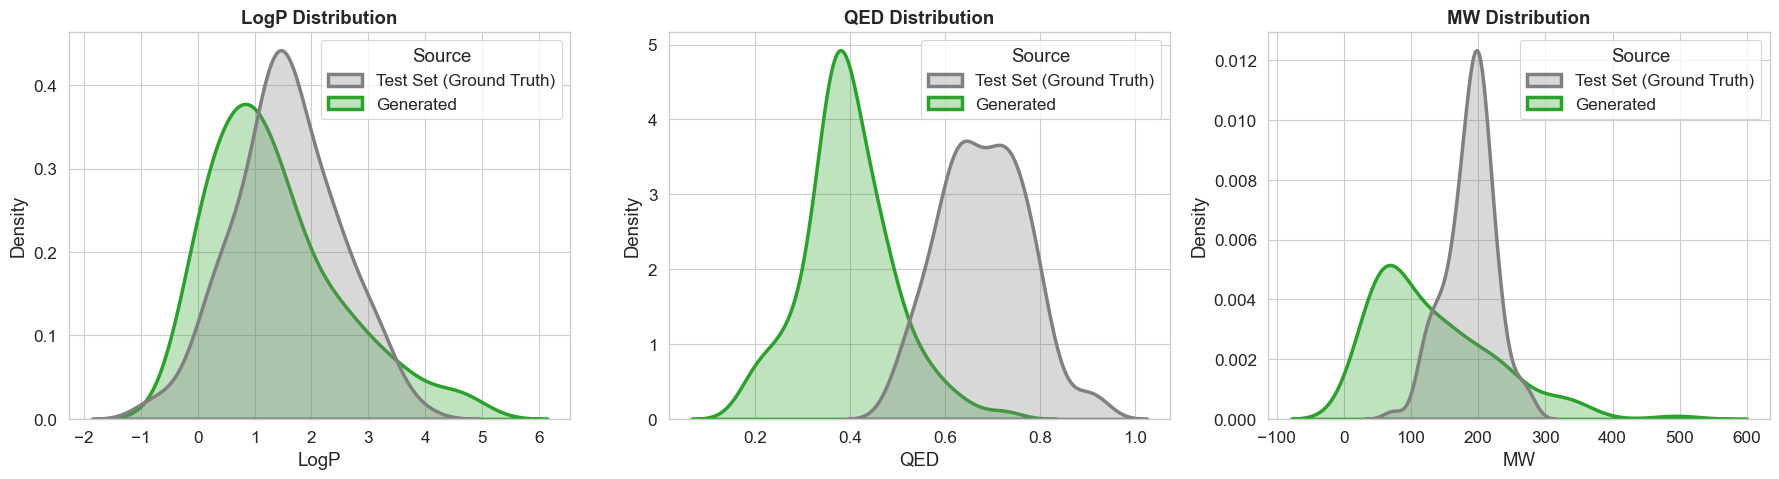

In [34]:
# Get Target Properties and DE-NORMALIZE them
gen_props_df, valid_indices = calculate_generated_properties(results_df)
test_props_df = results_df.loc[valid_indices, ['Target_LogP', 'Target_QED', 'Target_MW']].copy()

# Apply de-normalization (using the min/max values from your load_molecules.ipynb)
# You need to make sure min_logp, max_logp, etc. are available here!
test_props_df['Target_LogP'] = test_props_df['Target_LogP'].apply(lambda x: denormalize(x, min_logp, max_logp))
test_props_df['Target_QED'] = test_props_df['Target_QED'].apply(lambda x: denormalize(x, min_qed, max_qed))
test_props_df['Target_MW'] = test_props_df['Target_MW'].apply(lambda x: denormalize(x, min_mw, max_mw))

test_props_df.columns = ['LogP', 'QED', 'MW']
test_props_df['Source'] = 'Test Set (Ground Truth)'

combined_df = pd.concat([test_props_df, gen_props_df], axis=0) 

plot_property_distributions(combined_df)

Ranking molecules by Target-Match Accuracy...
Drawing top 9 most accurate generations...
Saved image to ../generation/best_matching_molecules_1000.png


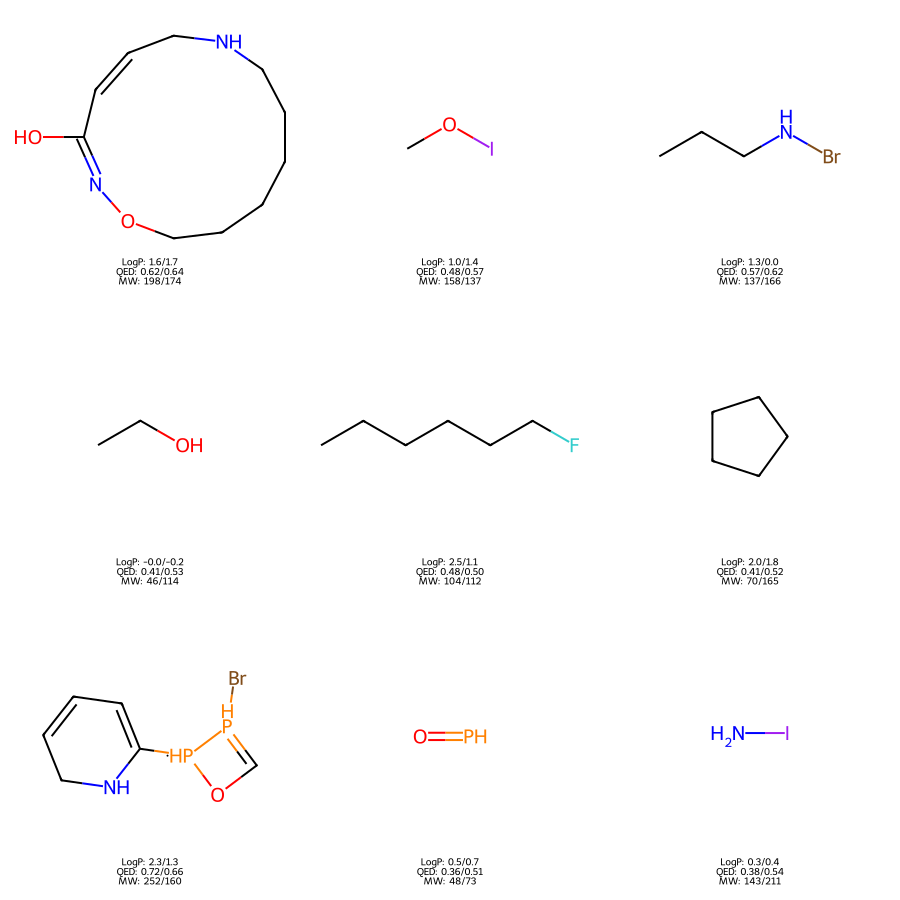

In [35]:
RESULTS_PATH = f"../generation/final_results_{N_MOLECS}_{time}.csv"
results_df = pd.read_csv(RESULTS_PATH)

print("Ranking molecules by Target-Match Accuracy...")

molecules_to_draw = []
errors = []

for idx, row in results_df.iterrows():
    smi = row['Generated_SMILES']
    if not smi or pd.isna(smi):
        continue
        
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        continue

    # A. Calculate Actual Properties
    act_logp = Descriptors.MolLogP(mol)
    act_qed = QED.qed(mol)
    act_mw = Descriptors.ExactMolWt(mol)
    
    # B. Get Target Properties (De-normalized)
    # Note: Ensure your CSV saved them as Normalized. 
    # If you saved de-normalized values already, skip the 'denorm' call.
    tgt_logp = denormalize(row['Target_LogP'], min_logp, max_logp)
    tgt_qed = denormalize(row['Target_QED'], min_qed, max_qed)
    tgt_mw = denormalize(row['Target_MW'], min_mw, max_mw)

    
    # C. Calculate Error (Mean Squared Error between Target and Actual)
    # We normalize the differences so MW doesn't dominate the error score
    # (e.g. MW error of 10 is small, but QED error of 10 is impossible)
    diff_logp = (act_logp - tgt_logp) ** 2
    diff_qed = (act_qed - tgt_qed) ** 2 * 100 # Scale up QED importance
    diff_mw = ((act_mw - tgt_mw) / 100) ** 2  # Scale down MW importance
    
    total_error = diff_logp + diff_qed + diff_mw
    
    molecules_to_draw.append({
        'mol': mol,
        'smiles': smi,
        'error': total_error,
        'legend': f"LogP: {act_logp:.1f}/{tgt_logp:.1f}\nQED: {act_qed:.2f}/{tgt_qed:.2f}\nMW: {act_mw:.0f}/{tgt_mw:.0f}"
    })

# --- 4. Sort and Select Top K ---
# Sort by lowest error (Best Match)
best_molecules = sorted(molecules_to_draw, key=lambda x: x['error'])[:9] # Top 9

# --- 5. Draw Grid ---
print(f"Drawing top {len(best_molecules)} most accurate generations...")

img = Draw.MolsToGridImage(
    [x['mol'] for x in best_molecules],
    molsPerRow=3,
    subImgSize=(300, 300),
    legends=[x['legend'] for x in best_molecules], # Shows Actual / Target
    returnPNG=False
)

# Display (if in notebook)
display(img)

------------------------------------------------------------------

## Stochastic Generation with Tempering

To generate novel molecules, we run the trained model autoregressively.
* **Tempering:** We apply a temperature factor $T$ to the logits ($p_i = \frac{\exp(z_i/T)}{\sum \exp(z_j/T)}$) to control the diversity of the output.
* **Masking:** We explicitly mask invalid start/pad tokens to ensure the generator produces syntactically valid sequences.

In [ ]:
N_MOLECS = 100  # Number of molecules to generate
MASTER_KEY = jax.random.PRNGKey(42)  # Fixed key for reproducibility
TEMPERATURE = 0.6  # Sampling temperature

# Target properties (mid-range example normalized to [0, pi])
desired_logp = 1.2
desired_qed = 0.71
desired_mw = 205.0

norm_logp = normalize(desired_logp, min_logp, max_logp)
norm_qed = normalize(desired_qed, min_qed, max_qed)
norm_mw = normalize(desired_mw, min_mw, max_mw)
desired_props = jnp.array([norm_logp, norm_qed, norm_mw], dtype=jnp.float32)

print(f"Target Properties (Normalized to [0, pi]):")
print(f"   LogP: {norm_logp:.3f}, QED: {norm_qed:.3f}, MW: {norm_mw:.3f}\n")


def generate_molecules(props, params):
    selfies_list = []
    smiles_list = []
    keys = jax.random.split(MASTER_KEY, N_MOLECS)
    for i in range(N_MOLECS):
        rng_i = keys[i]
        generated_bits = molecule_stochastic_generation(rng_i, props, params, temperature=TEMPERATURE)
        generated_selfies, generated_smiles = bits_to_selfies_smiles(generated_bits)
        selfies_list.append(generated_selfies)
        smiles_list.append(generated_smiles)
    return selfies_list, smiles_list

selfies_list, smiles_list = generate_molecules(desired_props, combined_params)

In [ ]:
def analyze_molecule_properties(selfies_list, smiles_list, target_logp, target_qed, target_mw):
    """
    Calculates and prints the physicochemical properties for generated molecules,
    comparing them directly against the denormalized targets.
    Args:
        selfies_list: List of generated SELFIES strings
        smiles_list: List of generated SMILES strings
        target_logp: Target LogP value (denormalized)
        target_qed: Target QED value (denormalized)
        target_mw: Target Molecular Weight (denormalized)
    Returns:
        DataFrame with properties of generated molecules and comparison to target
    """
    results = []
    
    # Print Denormalized Target Properties
    print(f"\n--- Target Properties ---")
    print(f"LogP: {target_logp:.2f}")
    print(f"QED: {target_qed:.2f}")
    print(f"MW: {target_mw:.2f} g/mol")
    print("-" * 35)

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # Handle empty/invalid SMILES from generation failure
        if not smiles:
            results.append({"Molecule": i+1, "SMILES": "N/A", "LogP": np.nan, "QED": np.nan, "MW": np.nan})
            continue

        mol = Chem.MolFromSmiles(smiles)

        if mol is not None:
            try:
                logp = Descriptors.MolLogP(mol)
                qed_score = QED.qed(mol)
                mw = Descriptors.ExactMolWt(mol)

                results.append({
                    "Molecule": i+1,
                    "SELFIES": selfies,
                    "SMILES": smiles,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw,
                    "Validity": "Valid"
                })
            except Exception:
                 results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Error"})
        else:
            results.append({"Molecule": i+1, "SELFIES": selfies, "SMILES": smiles, "LogP": np.nan, "QED": np.nan, "MW": np.nan, "Validity": "Invalid"})

    # Create and display the DataFrame
    df = pd.DataFrame(results)
    
    # Add a row for the target properties for easy comparison
    target_row = pd.Series({
        "Molecule": "TARGET", 
        "SELFIES": "TARGET",
        "SMILES": "TARGET", 
        "LogP": target_logp, 
        "QED": target_qed, 
        "MW": target_mw
    }, name="TARGET").to_frame().T
    
    # Concatenate the target row and the results for visual comparison
    df_styled = pd.concat([target_row.set_index('Molecule'), df.set_index('Molecule')])
    
    # Format numerical columns for presentation
    df_styled = df_styled.apply(pd.to_numeric, errors='ignore').round(2)
    
    return df_styled

df_styled = analyze_molecule_properties(selfies_list, smiles_list, desired_logp, desired_qed, desired_mw)

# Save the results to a CSV file
output_csv_path = f"../generation/generated_selfies_embedding{N_MOLECS}_{time}.csv"
df_styled.to_csv(output_csv_path)

In [ ]:
def get_top_molecules(selfies_list, smiles_list, top_k=5, min_mw=150.0, min_qed=0.5):
    """
    Filters generated molecules by validity and properties, then returns the top K
    sorted by QED (drug-likeness).
    Args:
        selfies_list: List of generated SELFIES strings
        smiles_list: List of generated SMILES strings
        top_k: Number of top molecules to return
        min_mw: Minimum molecular weight to consider
        min_qed: Minimum QED score to consider
    Returns:
        DataFrame of top K molecules with their properties
    """
    valid_molecules = []

    print(f"Analyzing {len(smiles_list)} generated molecules...")

    for i, (smiles, selfies) in enumerate(zip(smiles_list, selfies_list)):
        # 1. Basic Validity Check
        if not smiles:
            continue
            
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue

        try:
            # 2. Calculate Properties
            mw = Descriptors.ExactMolWt(mol)
            qed_score = QED.qed(mol)
            logp = Descriptors.MolLogP(mol)

            # 3. Apply Filters (The "Quality Control")
            # We want molecules that are large enough (MW > 150) to be interesting
            # and drug-like enough (QED > 0.5) to be valid candidates.
            if mw >= min_mw and qed_score >= min_qed:
                valid_molecules.append({
                    "Index": i,
                    "SMILES": smiles,
                    "SELFIES": selfies,
                    "LogP": logp,
                    "QED": qed_score,
                    "MW": mw
                })
        except Exception:
            continue

    # 4. Sort by QED (Best Drug-Likeness First)
    # You could also sort by similarity to target LogP if preferred
    valid_molecules.sort(key=lambda x: x['QED'], reverse=True)

    # 5. Select Top K
    top_molecules = valid_molecules[:top_k]
    
    print(f"Found {len(valid_molecules)} molecules passing filters.")
    print(f"Showing top {len(top_molecules)}:")

    return pd.DataFrame(top_molecules)


top_10_df = get_top_molecules(selfies_list, smiles_list, top_k=10)

# Display
pd.set_option('display.max_colwidth', 60) # Make columns wide enough to see strings
display(top_10_df)

In [ ]:
# Generate the Molecules
mols = [Chem.MolFromSmiles(s) for s in top_10_df['SMILES']]

# Generate the Grid Image
img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=3, 
    subImgSize=(300, 300), 
    legends=[top_10_df.iloc[i]['SMILES'] for i in range(len(mols))],
    returnPNG=False 
)

img.save(f"../generation/best_molecules_{N_MOLECS}_{time}.png")

display(img)